# Exercise: Enron Ensembles

In this exercise we will practice using ensemble methods to build a spam filter trained on the Enron email dataset.

The [Enron Corporation](https://en.wikipedia.org/wiki/Enron) was an energy company active between 1985 and 2004, famous for being investigated for accounting fraud in the "Enron scandal" of 2001. As part of the investigation, the United States Federal Energy Regulatory Commission obtained and published about 500,000 of the company's internal emails. The "silver lining" of the scandal was that this provided NLP researchers working on emails with a convenient dataset.


We will use this data to train a spam filter, using a processed version of the Enron dataset including labels for "ham" (non-spam) and spam emails, provided by the [NLP group at the Athens University of Economics and Business](http://nlp.cs.aueb.gr/software.html) (AUEB). We will compare boosting and bagging and examine how they are applied to this problem.

**Note:** This problem requires scikit-learn version 0.21 or above. Verify that this is installed before proceeding.

## Part 1: Data preprocessing

### Questions
1. Load the accompanying data file `enron.csv.gz` as a Pandas dataframe (use the `compression` attribute of `pandas.read_csv()`). Print out a random ham and spam full email in a readable format.

In [7]:
import pandas as pd

data = pd.read_csv("enron.csv.gz", compression="gzip")

random_ham = data[data["label"] == "ham"].sample(1)
print("Random Ham Email:")
print(random_ham["text"].values[0])

random_spam = data[data["label"] == "spam"].sample(1)
print("\nRandom Spam Email:")
print(random_spam["text"].values[0])


Random Ham Email:
Subject: re : rankings
louise , as per your email below , i am requesting your approval to change the supervisor for the below listed employees to jaime williams and steve irvin for the purpose of them obtaining feedback and accomplishments in order to supply you with a ranking .
enrique lenci - gonzales - associate
victor manual gonzales - associate
marc sabine - associate
augustin perez miranda - mgr origination
matthew duffy - mgr - origination
graciela perez leal - admin i
barbara martinez morales - admin ii
miguel angel rodriquez - clerk
julissa benevides - sr . admin
from : kitchen , louise
sent : thu 6 / 21 / 2001 11 : 52 am
to : williams , jaime ; irvin , steve
cc : melodick , kim
subject : rankings
can both of you get together and give me rankings for each of the following people .
i would like half a page on each of their accomplishments for this first half of 2001 and the same for each of you guys .
thanks
louise

Random Spam Email:
Subject: muscles , money

2. What words do you think would be more common in ham emails? What about in spam emails? Give a few examples.

Common words in ham emails:

    "Meeting"
    "Report"
    "Colleague"
    "Project"
    "Schedule"

Common words in spam emails:

    "Free"
    "Offer"
    "Discount"
    "Win"
    "Guaranteed"

3. How does it look like the text of the emails has been preprocessed by AUEB?

They likely preprocessed the text of the emails by performing typical NLP (Natural Language Processing) preprocessing steps, which could include:

    Tokenization
    Lowercasing
    Removing punctuation
    Removing stop words

4. Find the most common 20 words in ham emails and the most common 20 words in spam emails. (Hint: use `collections.Counter` and **Pandas** `str.split()`.  No additional preprocessing is necessary, and in this context, a word could be a punctuation sign). What do you notice about these words?

In [8]:
from collections import Counter

ham_emails = data[data["label"] == "ham"]["text"]
spam_emails = data[data["label"] == "spam"]["text"]

ham_word_counts = Counter(" ".join(ham_emails).split())
spam_word_counts = Counter(" ".join(spam_emails).split())

top_20_ham_words = ham_word_counts.most_common(20)
top_20_spam_words = spam_word_counts.most_common(20)

print("Top 20 words in ham emails:")
for word, count in top_20_ham_words:
    print(f"{word}: {count}")

print("\nTop 20 words in spam emails:")
for word, count in top_20_spam_words:
    print(f"{word}: {count}")

Top 20 words in ham emails:
-: 338963
.: 299086
,: 246026
the: 195851
/: 143336
to: 140645
:: 123028
and: 90980
of: 83277
a: 70227
enron: 65834
in: 65007
': 58825
for: 54466
@: 45874
on: 45252
ect: 43127
is: 41457
i: 41119
): 39112

Top 20 words in spam emails:
.: 298551
,: 186415
the: 132587
-: 124837
to: 105080
_: 92637
and: 91315
of: 86034
:: 66247
a: 65394
you: 61000
in: 56260
/: 53712
your: 44615
for: 43254
this: 42462
is: 41362
!: 41153
$: 30214
': 29076


What stands out in these lists is that the most common words in both ham and spam emails include a lot of punctuation marks and special characters, such as "-", ".", ... These characters don't necessarily carry significant meaning by themselves.
Additionally, both lists contain some common English stopwords such as "the", "and", "of",...These words are very frequent in the English language but don't provide much specific information about the content of the emails and if it should be considered a spam or a ham.

5. Convert the labels (ham/spam) to a numeric vector y, with entries 0 for ham emails and 1 for spam emails. (Hint: `y.shape` should be (38891,). You might use `pandas.Series.map`)

In [9]:
y = data["label"].map({"ham": 0, "spam": 1})

print("Shape of y:", y.shape)

Shape of y: (38891,)


6. Convert the text of emails to a feature matrix X whose rows are "bag of words" feature vectors using `sklearn.feature_extraction.text.CountVectorizer`, with `max_features=500`, `stop_words='english'`. (Hint: `X.shape` should be (38891, 500)).

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=500, stop_words='english')

X = vectorizer.fit_transform(data["text"])

print("Shape of X:", X.shape)

Shape of X: (38891, 500)


7. Look at the first row of `X` (`X[0, :].toarray()`). What do you think each number represents? Use the `CountVectorizer`'s `cv.get_feature_names()` or `cv.vocabulary_` to confirm your guess.  What's the most common word in the first email, what column number is it, and how many times does it appear in the email?

The first row of X, X[0, :].toarray(), represents the bag-of-words feature vector for the first email in the dataset. Each number in the array represents the frequency of the corresponding word in the email.

In [22]:
feature_names = vectorizer.get_feature_names_out()

column_number = X[0, :].toarray().argmax()

most_common_word = feature_names[column_number]

print("Most common word in the first email:", most_common_word)
print("Column number:", column_number)
print("Frequency in the email:", X[0, column_number])
print("\nText of the first email:")
print(data["text"][0])

Most common word in the first email: ena
Column number: 163
Frequency in the email: 9

Text of the first email:
Subject: ena sales on hpl
just to update you on this project ' s status :
based on a new report that scott mills ran for me from sitara , i have come up
with the following counterparties as the ones to which ena is selling gas off
of hpl ' s pipe .
altrade transaction , l . l . c . gulf gas utilities company
brazoria , city of panther pipeline , inc .
central illinois light company praxair , inc .
central power and light company reliant energy - entex
ces - equistar chemicals , lp reliant energy - hl & p
corpus christi gas marketing , lp southern union company
d & h gas company , inc . texas utilities fuel company
duke energy field services , inc . txu gas distribution
entex gas marketing company union carbide corporation
equistar chemicals , lp unit gas transmission company inc .
since i ' m not sure exactly what gets entered into sitara , pat clynes
suggested that i check w

8. (bonus) Use PCA with two components (`sklearn.decomposition.PCA`) to project X into two dimensions. Make a scatterplot of X values with different colors for ham and spam emails. Does it look like the features in X will be useful for identifying spam?

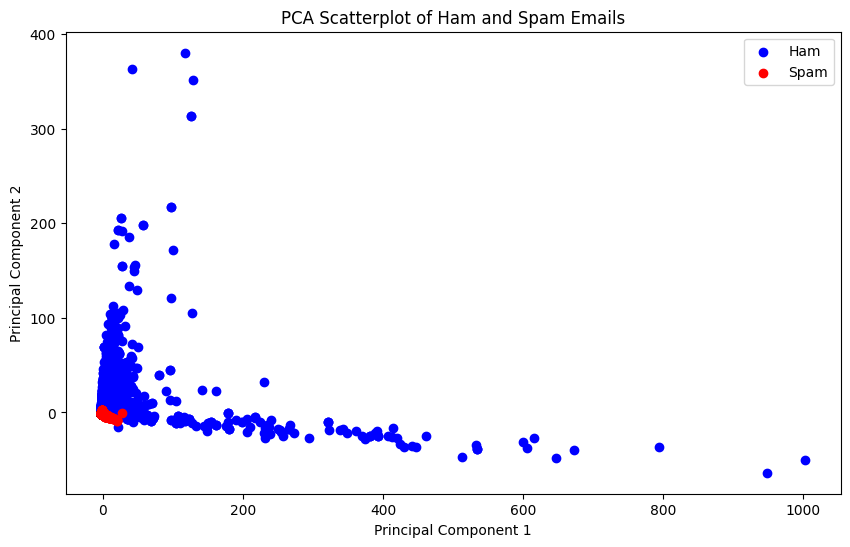

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Ham')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', label='Spam')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatterplot of Ham and Spam Emails')
plt.legend()
plt.show()


we can see on the plot that all the spam are in localised in the same area (x1 in (0,30) and x2 in (-10,10)) so the PCA transform is very useful for identifying spam

9. Split X and y into train and test sets using `sklearn.model_selection.train_test_split`. Use 80% of the data for training.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Part 2: Boosting

### Questions:

10. Train an AdaBoost classifier (`sklearn.ensemble.AdaBoostClassifier`, using `algorithm='SAMME'`) using the default base estimator of decision trees of depth one on your training data. Choose whatever number of estimators seems reasonable - giving us a better metric, but not taking too long. What accuracy, precision, and recall does this give on the test data?

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

adaboost_clf = AdaBoostClassifier(base_estimator=None, n_estimators=1, algorithm='SAMME', random_state=42)

adaboost_clf.fit(X_train, y_train)

y_pred = adaboost_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.7461113253631572
Precision: 0.6795911745619727
Recall: 1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


11. Which 10 words are most important for knowing if an email is spam? (Hint: use `AdaBoostClassifier.feature_importances_` and `argsort()`) Do these make sense to you?

In [27]:
feature_importances = adaboost_clf.feature_importances_
top_10_indices = feature_importances.argsort()[-10:]
top_10_words = [feature_names[i] for i in top_10_indices]

print("Top 10 words most important for identifying spam:")
for word in top_10_words:
    print(word)

Top 10 words most important for identifying spam:
cc
questions
http
2005
louise
attached
vince
2000
2001
enron


Some of these words make a lot of sense when it comes to identifying spam like 'questions', 'http', 'attached'

12. Use `AdaBostClassifier.estimators_`, `AdaBoostClassifier.estimator_weights_`, and `sklearn.tree.plot_tree` to plot the three most important decision trees in the ensemble. Would each decision tree alone overfit or underfit? (Hint: in `plot_tree` use the attributes `filled=True`, `proportion=True`, `class_names=['ham', 'spam']`, `feature_names=[array of words]`, and set fontsize so that the output is legible.)

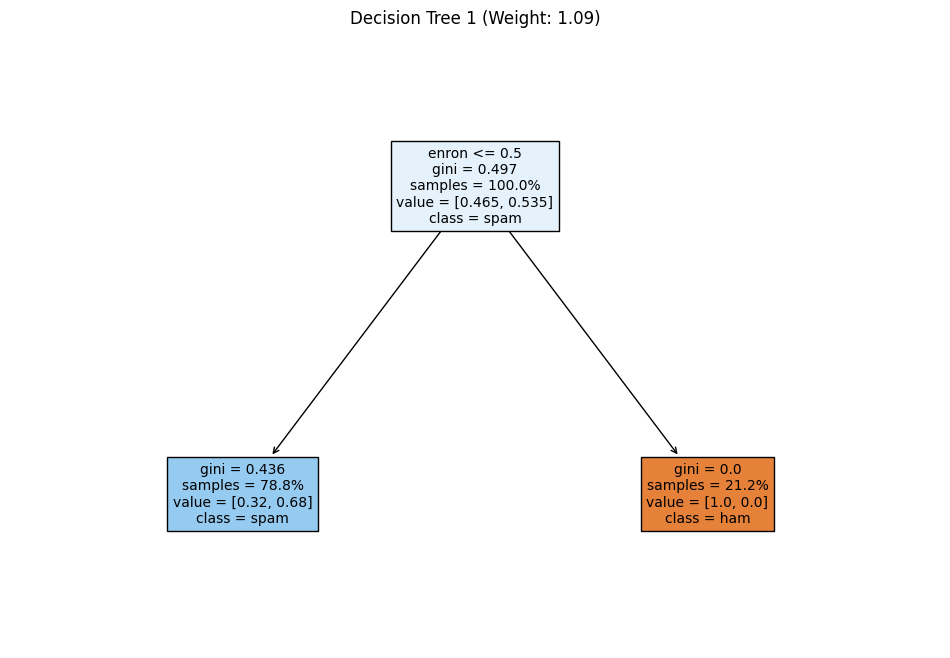

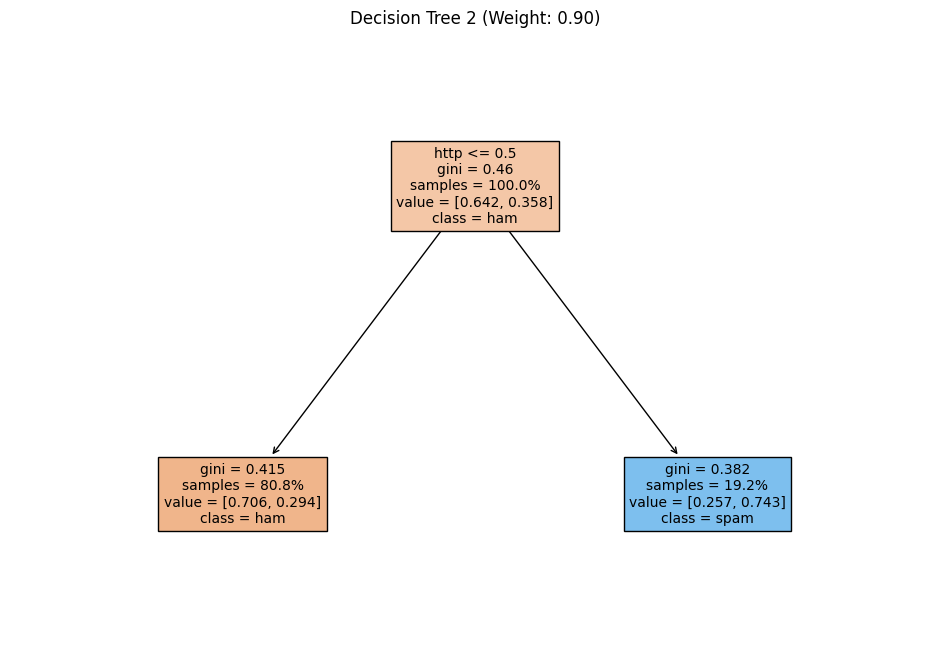

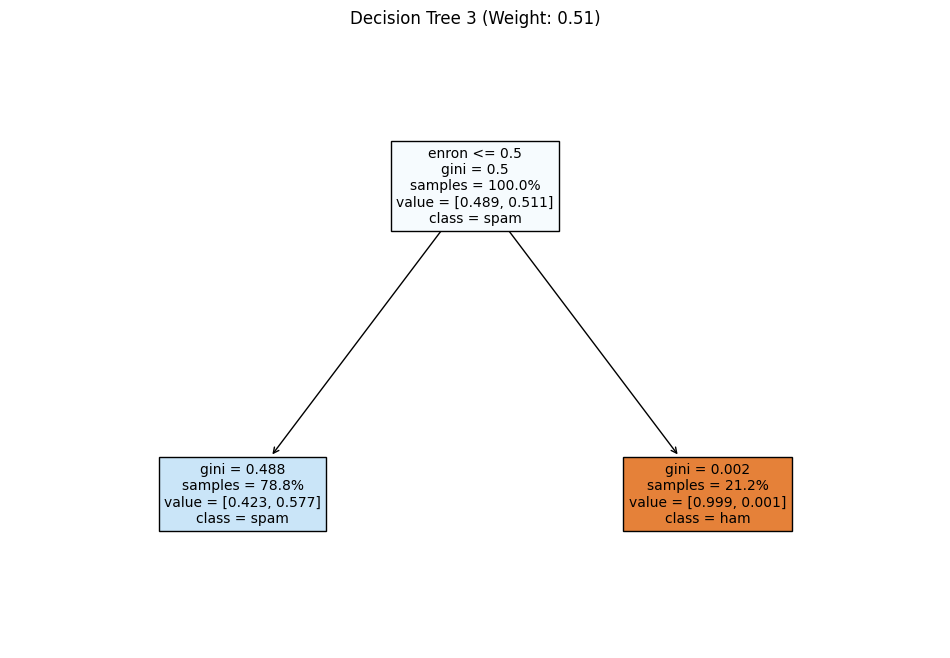

In [31]:
from sklearn.tree import plot_tree

top_3_trees = adaboost_clf.estimators_[:3]

tree_weights = adaboost_clf.estimator_weights_[:3]

for i, tree in enumerate(top_3_trees):
    plt.figure(figsize=(12, 8))
    plot_tree(tree, filled=True, proportion=True, class_names=['ham', 'spam'], feature_names=feature_names, fontsize=10)
    plt.title(f"Decision Tree {i+1} (Weight: {tree_weights[i]:.2f})")
    plt.show()

Each decision tree in AdaBoost might underfit the data individually due to their simplicity

## Part 3: Bagging

### Questions:
13. Train a Random Forest classifier (`sklearn.ensemble.RandomForestClassifier`) on the training data. Choose whatever number of estimators seems reasonable - giving us a better metric, but not taking too long. What accuracy, precision, and recall does this give on the test data?

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_clf.fit(X_train, y_train)

y_pred = random_forest_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9803316621673737
Precision: 0.9752708431464908
Recall: 0.9885414179995226


14. Which 10 words are most important for knowing if an email is spam? (Hint: use `RandomForestClassifier.feature_importances_` and `argsort()`) Do these make sense to you?

In [34]:
feature_importances = random_forest_clf.feature_importances_
top_10_indices = feature_importances.argsort()[-10:]
top_10_words = [feature_names[i] for i in top_10_indices]

print("Top 10 words most important for identifying spam:")
for word in top_10_words:
    print(word)

Top 10 words most important for identifying spam:
pm
713
vince
http
2000
thanks
attached
2001
cc
enron


We can see that a few of them are common to the 10 most important words when using a AdaBoost classifier (cc, http, attached, vince, 2000, 2001, enron)


15. Plot any one decision tree from the ensemble, using plot_tree. Use `max_depth` to limit the output. Do you think this tree alone would overfit or underfit new data?

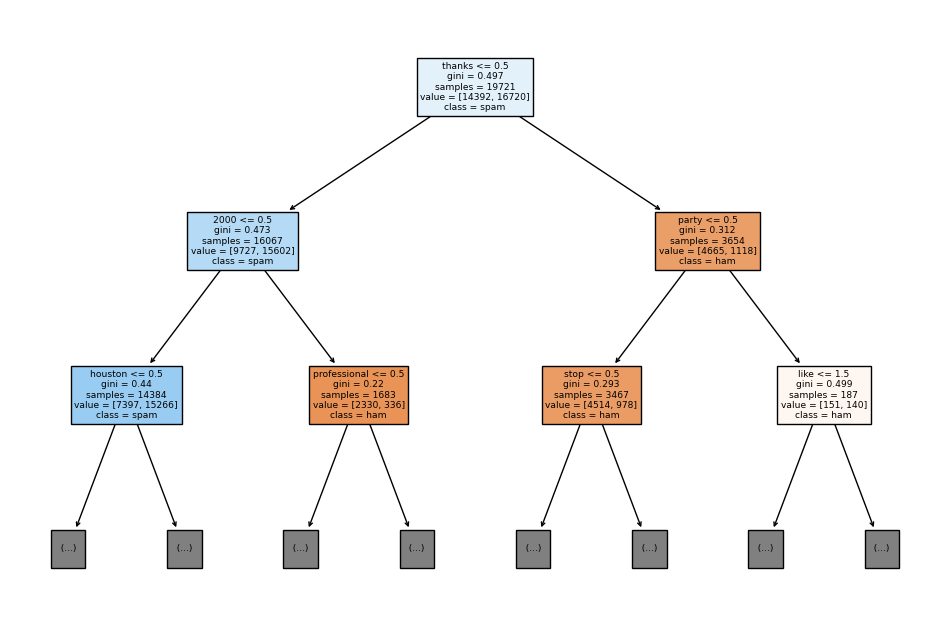

In [40]:
one_tree = random_forest_clf.estimators_[0]
plt.figure(figsize=(12, 8))
plot_tree(one_tree, filled=True, class_names=['ham', 'spam'], feature_names=feature_names, max_depth=2)
plt.show()

Given its limited depth, this decision tree would likely underfit new data. With only two levels of splits, the model's ability to capture complex patterns in the data is restricted, potentially leading to high bias.

## Part 4: Analysis

### Question:

16. Which of the two classifiers that we tested would you prefer for a spam filter, and why?

In [16]:
# your analysis here